<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/MultiLabel_FL_efficientnet_b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 213 kB 15.0 MB/s 
     |████████████████████████████████| 61 kB 9.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 11.1 MB/s 


{'restart': True, 'status': 'ok'}

In [2]:
!pip install wwf -q

Importamos las librerías necesarias:

In [3]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import *

In [4]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [5]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-20 14:58:42 URL:https://uccf3bc5cb0ae383b2f058ac846d.dl.dropboxusercontent.com/cd/0/inline2/BnnJrmaAv5MCHenU3TxSz3me6nZsLv9sRHHyUzT3x9T6-LF6BY4JpGOlfjxGK4-gq1nvLTgQ10cvk3liFmq-CTIoWEMYtEndc-yb6RgabgDgWIhfWngn3ZwrM1qYKr_jGYJBMTx9MjEdGai7zgz7g_rpGmX6yK1y7w9oGuv9SkSACUnsRLXpK4gJMB0R5WUa1q9MdXwEoLqST0iYKCxpRXmyppZY7wIrXSAMNTIfBdcCFHYG76FJ6MFPSgdg847wvENuculmGkDAYCVkJxkvYIv2gIz7aYgulk6s4CqPelFJKXzuSCplx-fRGzJngM1vlPYaJZpaIQyeA-XN3CybK--DcCaWJaDLae89oKtCpwZkx_A14J24Z9Fhc-6a7awk9cQEnOJur2AUmfY2r5EzWMrtwAf5VW6vSlgmB7DopAYqMg/file [138777773/138777773] -> "train.zip" [1]
2022-06-20 14:58:45 URL:https://uc18ae27b15dff53d7d83b8af906.dl.dropboxusercontent.com/cd/0/inline2/Bnnl0wdHeW6tzvLK7WH-FBFggiE9IaD-FECV7dsICoTC6_kPmM48kAJEGWYf4adR0oINn_W0-WrBLOzPfsNH9_iLFMMO5ho9xe6I8uLIs5WysdsXln_dbSQQUmgQ63jIUgy-2lN4Sa2tHohzSP7LuKeoEWwd3oR5wqXKrC-18jmnFyCYBPGDNjEID_cqj5rw_9EiDeov3tYePMmKhn4h4n7dL2qlHGW_6ZI1bejshYlR1uYPdunCF7103z6acIjF6ye0aDk4wU7rfq1FWvyOmQhBMm48c2JmpM_MekUHkf23g_fvBfRRgFKCOyj5FPGMR3-

In [6]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [9]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
def crearDataFrame(df, nombreConjunto):
  columnas = list(df.columns)[2:]

  nombres = [] #nombre de las imagenes
  enfermedades = [] #nombres de las enfermedades

  for i in df.index:
    cadena = ''
    nombres.append(nombreConjunto + str(df['ID'][i]))
    if df['Disease_Risk'][i] == 1:
      for x in columnas:
        if(df[x][i]==1):
          cadena += ' ' + x
    else:
      cadena = ' NORMAL'
    enfermedades.append(cadena[1:])
  data = {'nombre_img': nombres,
        'tags': enfermedades
        }
  return pd.DataFrame(data)

In [11]:
df_train_ML = crearDataFrame(df_train, str(trainPath) + '/Training/')
df_test_ML = crearDataFrame(df_test, str(testPath) + '/Test/')
df_val_ML = crearDataFrame(df_val, str(valPath) + '/Validation/')

In [12]:
df_train_ML.head(10)

,nombre_img,tags
0,Training_Set_Pre/Training/1,DR
1,Training_Set_Pre/Training/2,DR
2,Training_Set_Pre/Training/3,DR
3,Training_Set_Pre/Training/4,MH ODC
4,Training_Set_Pre/Training/5,DR LS
5,Training_Set_Pre/Training/6,ARMD MYA
6,Training_Set_Pre/Training/7,ARMD MYA
7,Training_Set_Pre/Training/8,ARMD MYA
8,Training_Set_Pre/Training/9,ERM
9,Training_Set_Pre/Training/10,NORMAL


In [13]:
df_train_ML['is_valid'] = False
df_val_ML['is_valid'] = True

In [14]:
df_train_val = pd.concat([df_train_ML, df_val_ML])

In [15]:
df_train_val

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH ODC,False
4,Training_Set_Pre/Training/5,DR LS,False
...,...,...,...
635,Evaluation_Set_Pre/Validation/636,TSLN,True
636,Evaluation_Set_Pre/Validation/637,TSLN,True
637,Evaluation_Set_Pre/Validation/638,NORMAL,True
638,Evaluation_Set_Pre/Validation/639,NORMAL,True


In [21]:
# df_train_val[df_train_val['nombre_img']=='val/640']['is_valid'].values[0]

In [17]:
def conjuntoImg(nombreImg):
  return True if df[df['nombre_img'] == nombreImg[0]]['is_valid'].values[0] else False

In [18]:
df = df_train_val

In [19]:
conjuntoImg(['Training_Set_Pre/Training/503','ODP', True])

False

## Datablock

In [ ]:
# batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [22]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=ColReader(0, suff='.png'),
                  splitter=FuncSplitter(conjuntoImg),
                  get_y=ColReader(1, label_delim=' '),
                  item_tfms = Resize(256),
                  batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [164]:
dls = db.dataloaders(df.values)

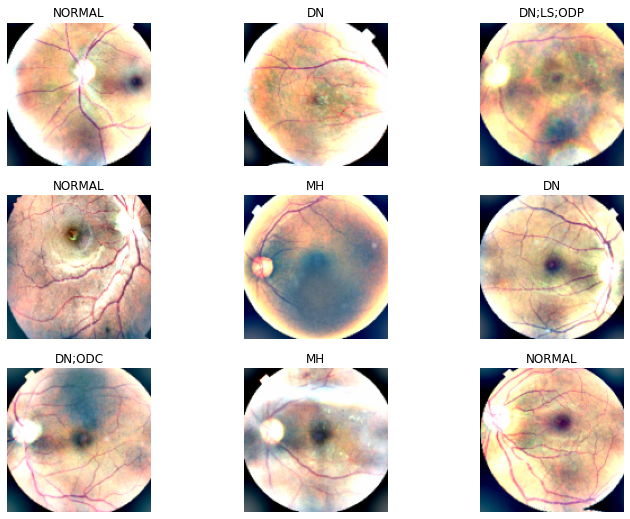

In [24]:
dls.show_batch()

## Entrenar Modelo

In [25]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [205]:
metrics = [ accuracy_multi, PrecisionMulti(), RecallMulti(), F1ScoreMulti() ]
learn = timm_learner(dls, 'efficientnet_b3', pretrained=True, metrics=metrics, loss_func=FocalLoss(), cbs=callbacks).to_fp16()

SuggestedLRs(minimum=0.010000000149011612, steep=0.002511886414140463)

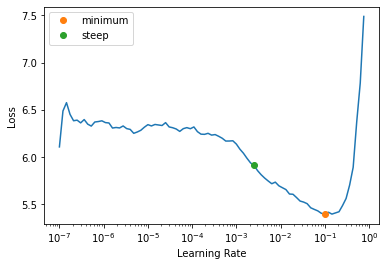

In [206]:
learn.lr_find(suggest_funcs=(minimum, steep))

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,5.200564,4.777069,0.563793,0.064873,0.547376,0.107799,00:15


Better model found at epoch 0 with valid_loss value: 4.777069091796875.


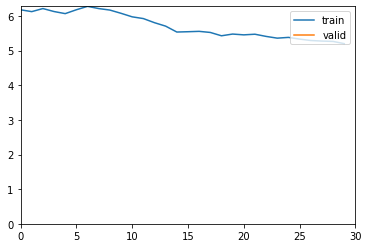

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,3.998011,3.377909,0.582381,0.066048,0.619064,0.111391,00:13
1,3.651929,3.246563,0.587392,0.066598,0.641128,0.112793,00:13
2,3.379194,3.035776,0.607004,0.067594,0.670185,0.114962,00:12
3,3.100457,2.967516,0.626832,0.065920,0.644884,0.112980,00:12
4,2.888385,2.825591,0.634483,0.066893,0.638357,0.115291,00:13
5,2.755268,2.688593,0.649246,0.070431,0.702791,0.122401,00:13
6,2.613191,2.680906,0.652425,0.069092,0.672487,0.120472,00:12
7,2.509904,2.636056,0.673545,0.068357,0.620733,0.119774,00:13
8,2.408857,2.648995,0.656088,0.070049,0.688047,0.123198,00:13
9,2.346523,2.670449,0.661153,0.070564,0.679754,0.124037,00:13


Better model found at epoch 0 with valid_loss value: 3.377908706665039.


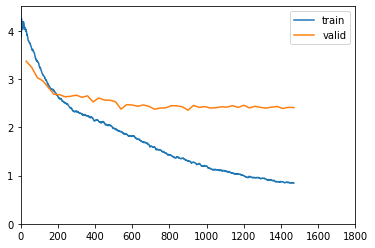

Better model found at epoch 1 with valid_loss value: 3.246562957763672.
Better model found at epoch 2 with valid_loss value: 3.035776376724243.
Better model found at epoch 3 with valid_loss value: 2.9675164222717285.
Better model found at epoch 4 with valid_loss value: 2.8255906105041504.
Better model found at epoch 5 with valid_loss value: 2.6885933876037598.
Better model found at epoch 6 with valid_loss value: 2.680906295776367.
Better model found at epoch 7 with valid_loss value: 2.6360557079315186.
Better model found at epoch 10 with valid_loss value: 2.6264054775238037.
Better model found at epoch 12 with valid_loss value: 2.5294625759124756.
Better model found at epoch 17 with valid_loss value: 2.3817591667175293.
Better model found at epoch 23 with valid_loss value: 2.379713773727417.
Better model found at epoch 29 with valid_loss value: 2.358652353286743.
No improvement since epoch 29: early stopping
CPU times: user 7min 15s, sys: 22.2 s, total: 7min 37s
Wall time: 11min 24s


In [207]:
%%time
learn.fine_tune(60,base_lr=1e-2)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


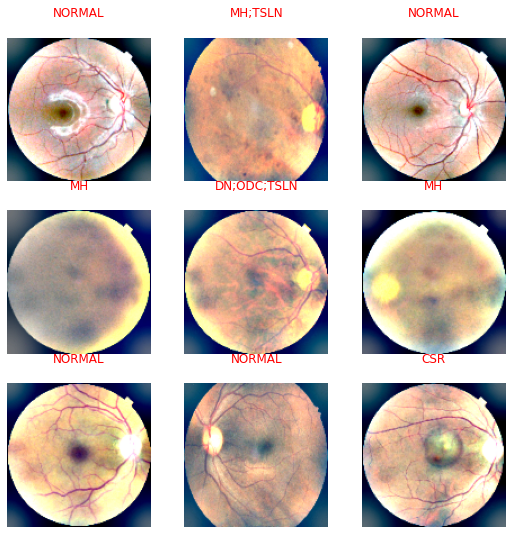

In [208]:
learn.show_results()

## Evaluar el modelo

In [216]:
dbTest = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = Resize(256),
                   batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [217]:
dlsTest = dbTest.dataloaders(df_test_ML)

In [218]:
learn.dls = dlsTest

In [219]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.7373383045196533.


(#5) [2.099137306213379,0.7373383045196533,0.09902417299877697,0.5977011494252873,0.16393457451333143]

Exportamos el modelo

In [220]:
learn.to_fp32()
learn.export('MultiLabel_FL_efficientnet_b3.pkl')

## Comprobaciones manuales

In [221]:
learn_inf = load_learner('MultiLabel_FL_efficientnet_b3.pkl')

In [222]:
df_test[df_test['Disease_Risk']==1] #enfermedad

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
637,638,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
638,639,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [223]:
df_test[df_test['Disease_Risk']==0] #sanas
# df_test.iloc[0:20,:]

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
244,245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625,626,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
627,628,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Imágenes con enfermedad**

In [224]:
learn_inf.predict('Test_Set_Pre/Test/1.png')[0] #DR, TLSN

(#0) []

In [225]:
learn_inf.predict('Test_Set_Pre/Test/2.png')[0] #DR, BRVO

(#0) []

In [226]:
learn_inf.predict('Test_Set_Pre/Test/3.png')[0] #DR, ODC

(#0) []

In [227]:
learn_inf.predict('Test_Set_Pre/Test/10.png')[0] #DR, LS, ODC

(#0) []

**Imágenes normales:**

In [228]:
learn_inf.predict('Test_Set_Pre/Test/272.png')[0]

(#0) []

In [229]:
learn_inf.predict('Test_Set_Pre/Test/623.png')[0]

(#0) []

In [230]:
learn_inf.predict('Test_Set_Pre/Test/626.png')[0]

(#0) []

In [231]:
learn_inf.predict('Test_Set_Pre/Test/628.png')[0]

(#0) []

In [235]:
learn_inf.predict('Test_Set_Pre/Test/629.png')[0]

(#0) []